# 2022-05-13 • Network conntest Roxin params

## Imports

In [2]:
#

In [3]:
using Revise

In [4]:
using MyToolbox

In [5]:
using VoltoMapSim

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]


## Params

Based on Roxin (see previous nb).

In [48]:
d = 6
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
);
# dumps(p)

## Run sim

In [49]:
s = cached(sim, [p.sim]);

Uncached output:
```
Running simulation: 100%|███████████████████████████████| Time: 0:11:31
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\sim\b77ff1c19d7f1e33.jld2` … done (0.7 s)
```

In [50]:
import PyPlot

In [51]:
using VoltoMapSim.Plot

In [52]:
tlim = @. 3minutes + [0,10]seconds;
tlim = [0,10]seconds;

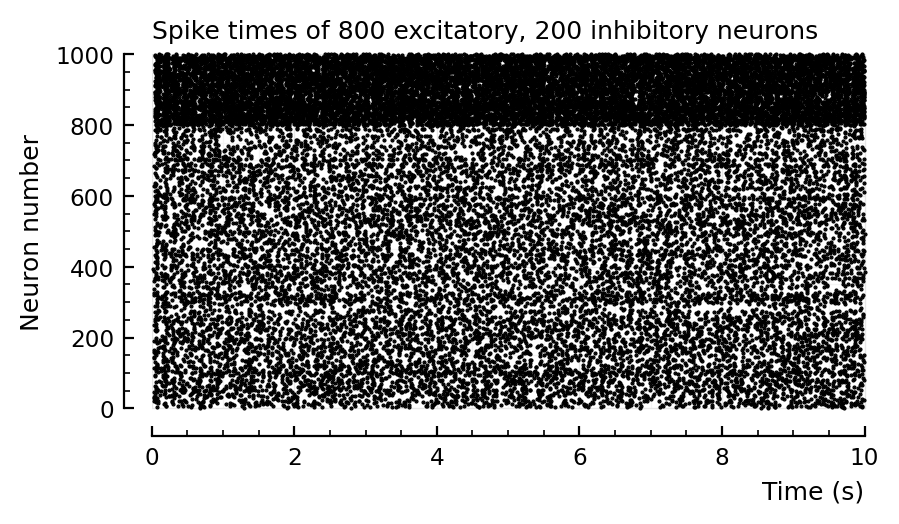

In [53]:
rasterplot(s.spike_times; tlim);

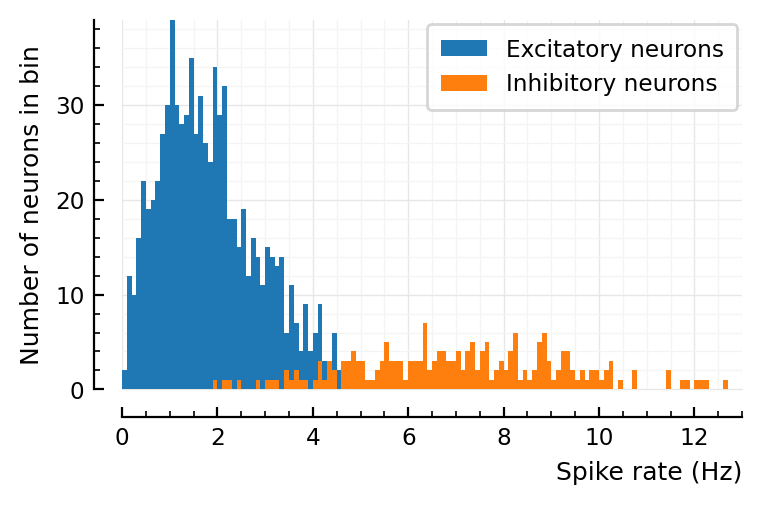

In [54]:
spike_rates = length.(s.spike_times) ./ p.sim.general.duration
histplot_fr(spike_rates);

In [55]:
# VI_sigs = add_VI_noise(s.voltage_traces, p);

In [56]:
# ax = plotsig(s.timesteps, VI_sigs[1] / mV; tlim, label="VI signal");
# ax = plotsig(s.timesteps, s.signals[1] / mV; tlim, ax, label="Membrane voltage")
# legend(ax, reorder=[2=>1])
# set(ax, xlabel="Simulation time (s)", ylabel="mV");

## Connection test

In [57]:
analyzed_neuron = 1;  # neuron ID

In [58]:
v = s.signals[analyzed_neuron].v;

In [59]:
input_neurons = s.input_neurons[analyzed_neuron]
length(input_neurons)

36

In [60]:
input_neurons_by_type = CVec(exc=[n for n in input_neurons if s.neuron_type[n] == :exc],
                             inh=[n for n in input_neurons if s.neuron_type[n] == :inh])

ComponentVector{Int64}(exc = [11, 33, 66, 70, 101, 132, 136, 139, 145, 169  …  446, 447, 516, 565, 597, 629, 681, 710, 766, 800], inh = [829, 831, 894, 897, 902, 908, 914, 922, 928, 988])

In [61]:
length(input_neurons_by_type.exc),
length(input_neurons_by_type.inh)

(26, 10)

In [62]:
unconnected_neurons = [n for n in s.neuron_IDs if n ∉ input_neurons && n != analyzed_neuron];
length(unconnected_neurons)

963

Highest firing inputs

In [63]:
sort!(collect(zip(input_neurons, spike_rates[input_neurons])), by = tup -> tup[2])

36-element Vector{Tuple{Int64, Float64}}:
 (337, 0.15166666666666667)
 (33, 0.29)
 (136, 0.6233333333333333)
 (516, 0.6833333333333333)
 (800, 0.8316666666666667)
 (70, 0.8333333333333334)
 (66, 0.94)
 (169, 0.9583333333333334)
 (303, 1.1983333333333333)
 (145, 1.265)
 (629, 1.3066666666666666)
 (101, 1.3183333333333334)
 (418, 1.4066666666666667)
 ⋮
 (922, 3.41)
 (565, 4.463333333333333)
 (908, 4.6866666666666665)
 (312, 4.841666666666667)
 (829, 6.091666666666667)
 (897, 7.963333333333333)
 (831, 8.803333333333333)
 (914, 8.816666666666666)
 (928, 8.938333333333333)
 (902, 10.166666666666666)
 (894, 11.481666666666667)
 (988, 11.76)

In [64]:
highest_firing_inputs = sort(input_neurons, by = id -> spike_rates[id], rev = true);
highest_firing_inputs[1]

988

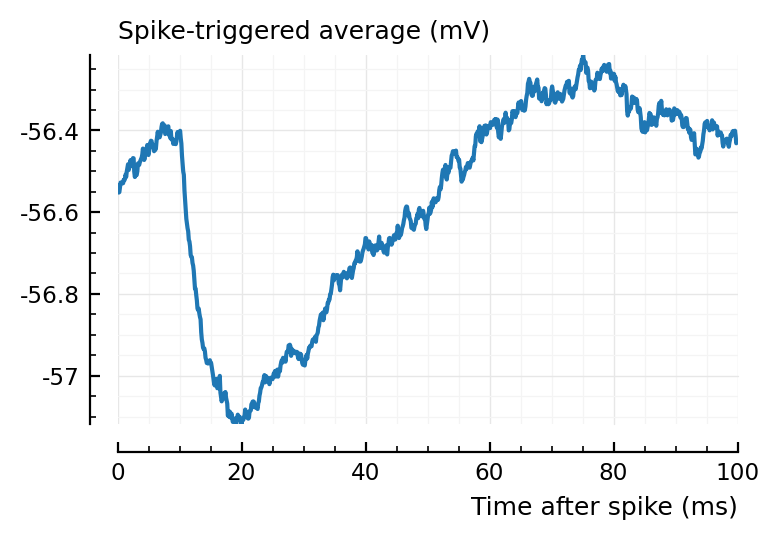

In [67]:
plotSTA(v, s.spike_times[highest_firing_inputs[1]], p);

In [69]:
highest_firing_exc_inputs = [n for n in highest_firing_inputs if s.neuron_type[n] == :exc]
highest_firing_inh_inputs = [n for n in highest_firing_inputs if s.neuron_type[n] == :inh]
highest_firing_exc_inputs[1], highest_firing_inh_inputs[1]

(312, 988)

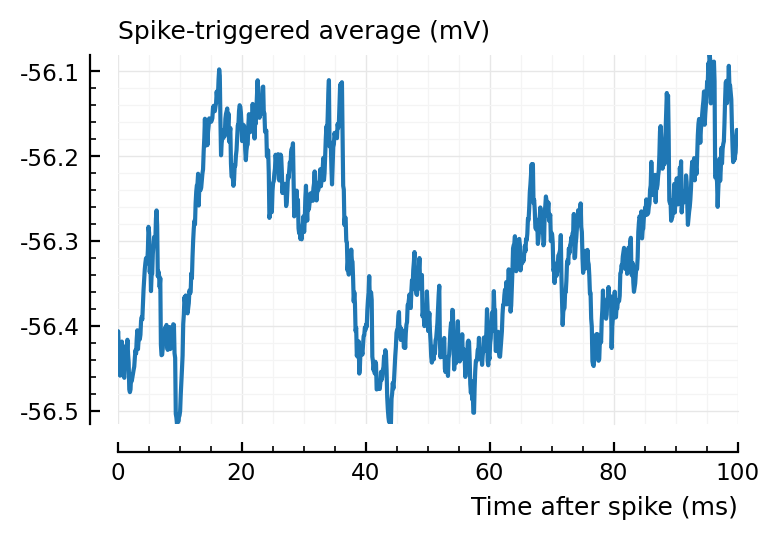

In [76]:
plotSTA(v, s.spike_times[highest_firing_exc_inputs[1]], p);

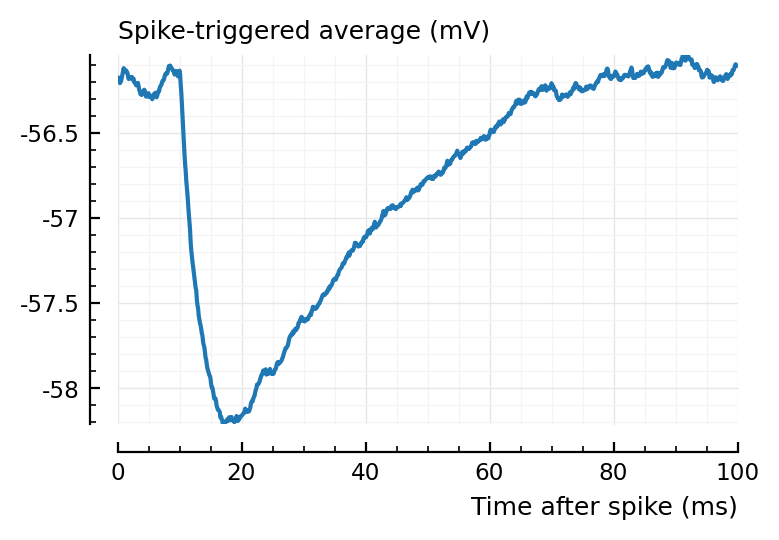

In [91]:
plotSTA(v, s.spike_times[highest_firing_inh_inputs[2]], p);

So I→E STAs are much cleaner. This is likely bc their synaptic weights are 36x larger.

In [89]:
spiketrains_by_type = (;
    conn = (;
        exc = [s.spike_times[n] for n in input_neurons_by_type.exc],
        inh = [s.spike_times[n] for n in input_neurons_by_type.inh],
    ),
    unconn = [s.spike_times[n] for n in unconnected_neurons],
);

In [90]:
perf = evaluate_conntest_perf(v, spiketrains_by_type, p)

Testing connections: 100%|██████████████████████████████| Time: 0:01:089m


(TPR_exc = 0.23076923076923078, TPR_inh = 1.0, FPR = 0.09999999999999998, p_values = (conn = (exc = Any[0.01, 0.84, 0.8, 0.96, 0.84, 0.6, 0.02, 0.87, 0.46, 0.63  …  0.37, 0.64, 0.3, 0.64, 0.02, 0.34, 0.61, 0.55, 0.37, 0.64], inh = Any[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]), unconn = Any[0.56, 0.08, 0.01, 0.03, 0.28, 0.72, 0.33, 0.46, 0.94, 0.15  …  0.37, 0.37, 0.94, 0.05, 0.87, 0.9, 0.19, 0.97, 0.11, 0.31]))

All inhibitory detected! :D

This is cause I changed reversal potential from -65 to -80 mV (following Roxin).

----

Check whether detected exc inputs are the highest firing ones.

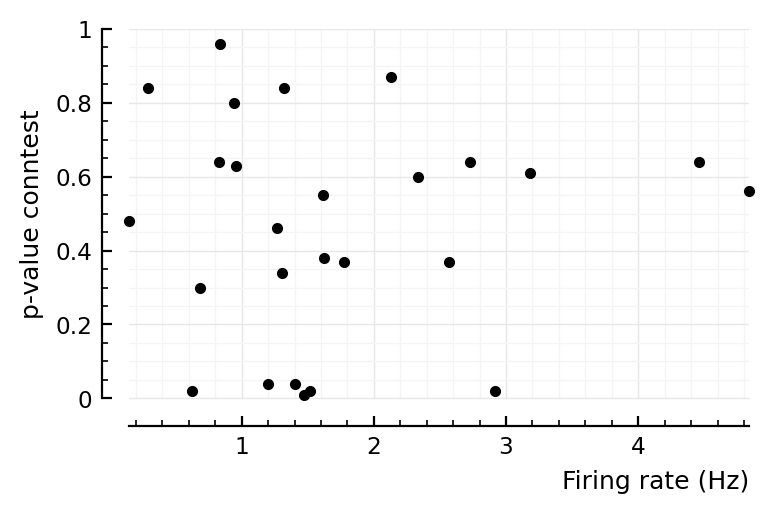

In [109]:
fr = Float64[]
pval = Float64[]
for (i,n) in enumerate(input_neurons_by_type.exc)
    push!(fr, spike_rates[n])
    push!(pval, perf.p_values.conn.exc[i])
end
ax = plot(fr, pval, "k.", clip_on = false, xlabel="Firing rate (Hz)", ylabel="p-value conntest", ylim=(0,1));

No, doesn't seem like it.

Plot STA of detected exc inputs.

In [120]:
show(perf.p_values.conn.exc)

Any[0.01, 0.84, 0.8, 0.96, 0.84, 0.6, 0.02, 0.87, 0.46, 0.63, 0.38, 0.04, 0.56, 0.48, 0.02, 0.04, 0.37, 0.64, 0.3, 0.64, 0.02, 0.34, 0.61, 0.55, 0.37, 0.64]

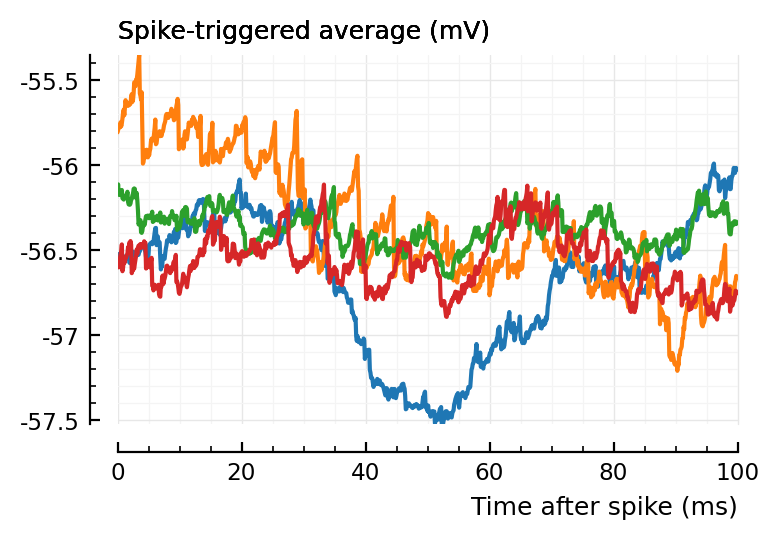

In [131]:
N = length(input_neurons_by_type.exc)
for i in sortperm(perf.p_values.conn.exc)[[1,2,N-1,N]]
    plotSTA(v, s.spike_times[input_neurons_by_type.exc[i]], p)
end

blue and orange are the two lowest p-values, green and red the highest (worst, undetected).